Import needed libraries.

In [124]:
import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
import us

Configure `matplotlib`.

In [125]:
%matplotlib inline

Load state shapefile and check out the first couple rows.

In [126]:
states = gpd.read_file(
    "../source_data/states_simple/states_simple.shp"
)

states.head(2)

,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,54,01779805,54,WV,West Virginia,00,62266474513,489028543,+38.6472854,-080.6183274,"POLYGON ((1561571.961 -483477.971, 1561619.813..."
1,12,00294478,12,FL,Florida,00,138949136250,31361101223,+28.4574302,-082.4091477,"MULTIPOLYGON (((1300534.538 -1450505.843, 1300..."


Now load wind power plant locations and check the first couple rows.

**Note:** This is a subset of the data we used in Part III, limited to only the facilities that are primarily wind-powered for faster loading.

In [129]:
wind_power_plants = gpd.read_file(
    "../source_data/wind_power_plants/wind_power_plants.shp"
)

wind_power_plants.head(2)

,Plant_Code,Plant_Name,Utility_Na,Utility_ID,sector_nam,City,County,StateName,Zip,Street_Add,...,Geo_MW,Bat_MW,Other_MW,source_des,tech_desc,Source,Period,Latitude,Longitude,geometry
0,508,Lamar Plant,City of Lamar - (CO),10633,Electric Utility,Lamar,Prowers,Colorado,81052,100 North Second Street,...,None,None,None,"Petroleum = 2 MW, Wind = 5.5 MW",Petroleum Liquids; Onshore Wind Turbine;,"EIA-860, EIA-860M and EIA-923",201910,38.033327,-102.537915,POINT (-102.53791 38.03333)
1,692,Medicine Bow,None,62891,IPP Non-CHP,Medicine Bow,Carbon,Wyoming,82329,475 Carbon Co. Rd. 3,...,None,None,None,Wind = 6.1 MW,Onshore Wind Turbine,"EIA-860, EIA-860M and EIA-923",201910,41.835278,-106.242778,POINT (-106.24278 41.83528)


## Geospatial merging

Use the `gpd.sjoin()` function to join DataFrames based on their `geometry` values.

In [130]:
merged = gpd.sjoin(
    states,
    wind_power_plants,
    how = "left",
)

/Users/ajvestal/Code/geopandas20/.venv/lib/python3.6/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:2163 != epsg:4326)
  "(%s != %s)" % (left_df.crs, right_df.crs)


Whoops! That error means the coordinate systems (or CRSes) for these two DataFrames don't match.

Let's get more info about the CRS each DataFrame is using.

In [131]:
states.crs

<Projected CRS: EPSG:2163>
Name: US National Atlas Equal Area
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: USA
- bounds: (167.65, 15.56, -65.69, 74.71)
Coordinate Operation:
- name: US National Atlas Equal Area
- method: Lambert Azimuthal Equal Area (Spherical)
Datum: Not specified (based on Clarke 1866 Authalic Sphere)
- Ellipsoid: Clarke 1866 Authalic Sphere
- Prime Meridian: Greenwich

In [132]:
wind_power_plants.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We want both DataFrames to use the same CRS.

Let's convert the `states` DataFrame to the relatively standard `EPSG:4326` system.

In [133]:
states = states.to_crs('epsg:4326')

Now we can try that merge again.

In [134]:
merged = gpd.sjoin(
    states,
    wind_power_plants,
    how = "left",
)

No errors this time! Let's have a look at the first couple rows:

In [135]:
merged.head(3)

,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,INTPTLAT,INTPTLON,...,Wind_MW,Geo_MW,Bat_MW,Other_MW,source_des,tech_desc,Source,Period,Latitude,Longitude
0,54,01779805,54,WV,West Virginia,00,62266474513,489028543,+38.6472854,-080.6183274,...,100.5,None,None,None,Wind = 100.5 MW,Onshore Wind Turbine,"EIA-860, EIA-860M and EIA-923",201910.0,38.0878,-80.4925
0,54,01779805,54,WV,West Virginia,00,62266474513,489028543,+38.6472854,-080.6183274,...,97.6,None,16.0,None,"Battery = 16 MW, Wind = 97.6 MW",Batteries; Onshore Wind Turbine;,"EIA-860, EIA-860M and EIA-923",201910.0,39.0072,-79.8866
0,54,01779805,54,WV,West Virginia,00,62266474513,489028543,+38.6472854,-080.6183274,...,66.0,None,None,None,Wind = 66 MW,Onshore Wind Turbine,"EIA-860, EIA-860M and EIA-923",201910.0,39.1828,-79.5372


## Analyzing the merged values

Group by state FIPS Code, then convert back to a plottable GeoDataFrame.

In [136]:
# Create an empty column that will hold state-by-state counts.
merged['plants_per_state'] = 0

# Group by state FIPS Code.
grouped = merged.groupby("STATEFP").agg({
    "plants_per_state": "count",  # This field gets the per-state count of wind facilities.
    "geometry": "first",  # The 'first' option preserves this column's original value.
    "STATEFP": "first",
    "NAME": "first"
})

# Now that grouping is done, convert the pandas DataFrame to a GeoPandas GeoDataFrame.
plants_by_state = gpd.GeoDataFrame(grouped)

Let's see which states have the most wind power plants.

In [137]:
plants_by_state.sort_values(
    "plants_per_state",
    ascending = False
).head()

,plants_per_state,geometry,STATEFP,NAME
STATEFP,,,,
48,176,"POLYGON ((-103.98018 32.00012, -103.97994 32.0...",48,Texas
27,128,"POLYGON ((-96.78438 46.63050, -96.78434 46.630...",27,Minnesota
06,119,"MULTIPOLYGON (((-124.13656 41.46445, -124.1378...",06,California
19,101,"POLYGON ((-96.49878 42.56104, -96.48707 42.572...",19,Iowa
40,51,"POLYGON ((-100.00376 36.49985, -100.00397 36.4...",40,Oklahoma


Make a quick plot of these values.

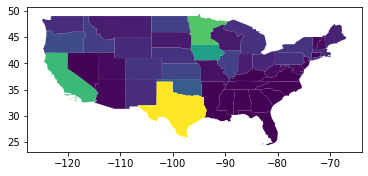

In [138]:
plants_by_state.plot(
    column = "plants_per_state",
    vmin=0
)

Get the maximum number of wind power plants in any state, for setting our scale.

In [139]:
plants_by_state['plants_per_state'].max()

176

Now make the map prettier and add a title and a scale.

Text(0.5, 1, 'Wind power plants in America')

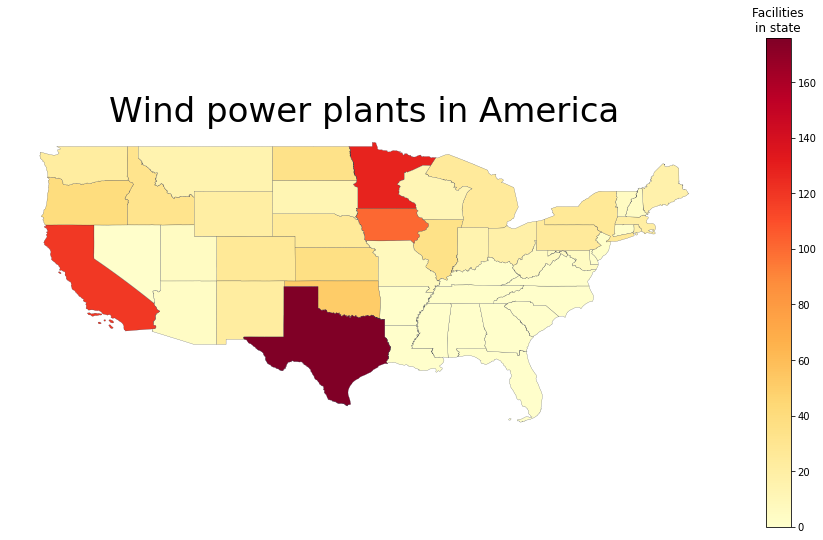

In [140]:
fig, ax = plt.subplots( figsize = (16, 9) )

plants_by_state.plot(
    ax = ax,
    cmap = "YlOrRd",
    column = 'plants_per_state',
    edgecolor = "#282D40",
    legend=True,
    linewidth = 0.2,
    vmin = 0,
    vmax = 176,
)

ax.axis("off")

scale = ax.get_figure().get_axes()[1]

scale.set_title("Facilities\nin state")

ax.set_title("Wind power plants in America", fontsize = 34)

Let's re-project to the prettier "EPSG:2163" CRS.

In [141]:
plants_reprojected = plants_by_state.to_crs('epsg:2163')

ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

That error means we never specified a CRS for `plants_by_state` when we created it.

We can add that here and try reprojecting again.

In [142]:
plants_by_state.crs = "EPSG:4326"

plants_reprojected = plants_by_state.to_crs('epsg:2163')

Now let's plot the reprojected data.

Text(0.5, 1, 'Wind power plants in America')

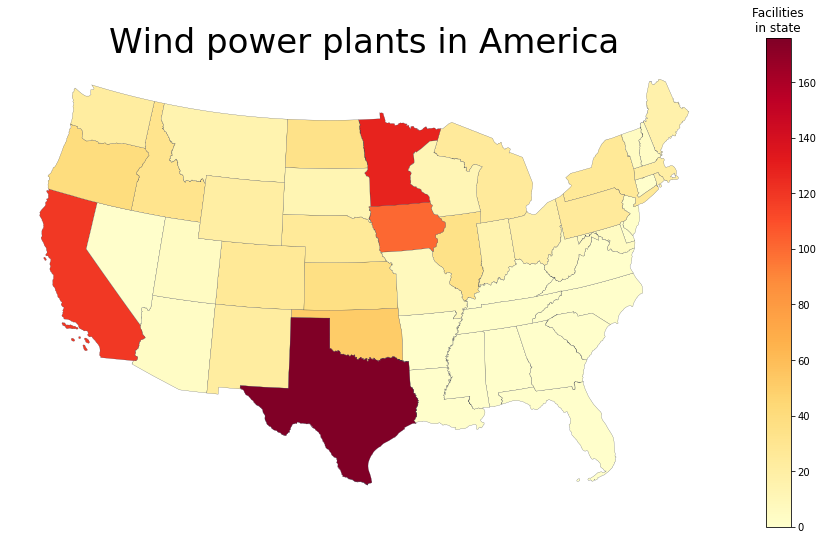

In [143]:
fig, ax = plt.subplots( figsize = (16, 9) )

plants_reprojected.plot(
    ax = ax,
    cmap = "YlOrRd",
    column = 'plants_per_state',
    edgecolor = "#282D40",
    legend=True,
    linewidth = 0.2,
    vmin = 0,
    vmax = 176,
)

ax.axis("off")

scale = ax.get_figure().get_axes()[1]

scale.set_title("Facilities\nin state")

ax.set_title("Wind power plants in America", fontsize = 34)

We can also add the individual plant locations to our plot:

In [144]:
reprojected_plants = wind_power_plants.to_crs('epsg:2163')

Text(0.5, 1, 'Wind power plants in America')

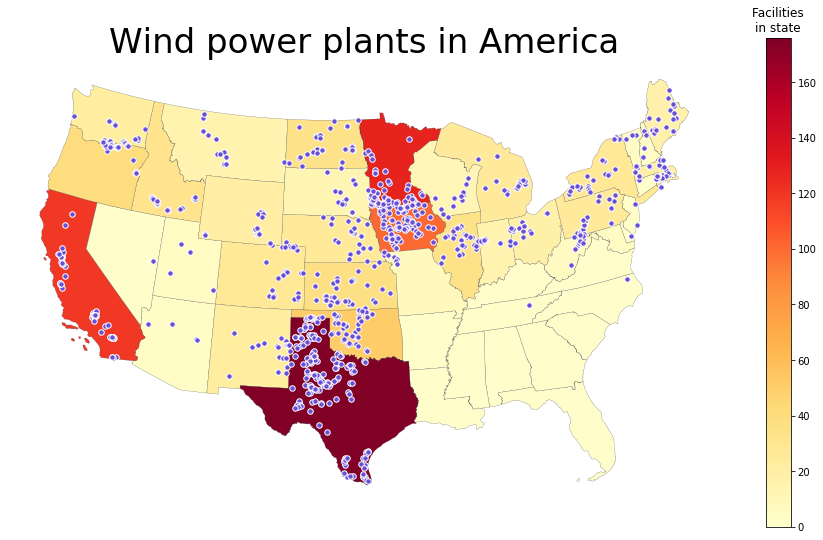

In [145]:
fig, ax = plt.subplots( figsize = (16, 9) )

plants_reprojected.plot(
    ax = ax,
    cmap = "YlOrRd",
    column = 'plants_per_state',
    edgecolor = "#282D40",
    legend=True,
    linewidth = 0.2,
    vmin = 0,
    vmax = 176,
)

reprojected_plants.plot(
    ax = ax,
    markersize = 30,
    color = "#694ED6",
    edgecolor = "white",
    linewidth = 1,
)

ax.axis("off")

scale = ax.get_figure().get_axes()[1]

scale.set_title("Facilities\nin state")

ax.set_title("Wind power plants in America", fontsize = 34)

Finally, save this map as an image.

In [146]:
fig.savefig(
    f"../output-images/04__us-wind-power.png", 
    transparent = False,
    bbox_inches = "tight"
)